# Exercise 8

Andres Felipe Díaz Méndez - 201924178

Arvid Tenganá Hurtado - 201527819

Juan David Barreto Pérez- 202020148

Juan Felipe Martínez Ramos - 201113765

Luis Miguel Torres Aponte - 202022939

## Car Price Prediction

Predict if the price of a car is low or high

In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('../datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [5]:
data.shape

(13150, 10)

In [6]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Exercise 8.1

Estimate a Decision Tree Classifier Manually using the code created in the decision trees notebook.

Evaluate the accuracy on the testing set

In [13]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [14]:
from sklearn.metrics import accuracy_score

tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)
y_predicted = tree_predict(X_test, tree)

accuracy_score(y_test, y_predicted)

0.8610599078341014

# Exercise 8.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in bagging notebook.

Evaluate the accuracy on the testing set

In [55]:
np.random.seed(42)

n_samples = train.shape[0]
n_trees = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_trees +1 )]

In [56]:
from sklearn.tree import DecisionTreeClassifier

accuracy_scores = []
tree = DecisionTreeClassifier(max_depth=None)

for i, sample in enumerate(samples):
    
    subsample = X_train.iloc[sample, :]
    label = y_train.iloc[sample]
    
    tree.fit(subsample,label)
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    print(i, accuracy_score(y_test, y_pred))
    
ensemble_accuracy = sum(accuracy_scores) / float(len(accuracy_scores))
print("Bagged Trees Accuracy:" + str(ensemble_accuracy))

0 0.8281105990783411
1 0.8361751152073733
2 0.8352534562211982
3 0.8366359447004609
4 0.8299539170506912
5 0.8391705069124424
6 0.8274193548387097
7 0.8380184331797235
8 0.8288018433179724
9 0.8352534562211982
Bagged Trees Accuracy:0.8334792626728109


# Exercise 8.3

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [107]:
from sklearn.ensemble import BaggingClassifier

accuracy_scores = []
max_features = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

for i in max_features:
    bagged_trees = BaggingClassifier(base_estimator = DecisionTreeClassifier(), 
                                     n_estimators = 10, 
                                     random_state = 42, 
                                     max_features = i )
    bagged_trees.fit(X_train, y_train)
    y_pred = bagged_trees.predict(X_test)
    accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

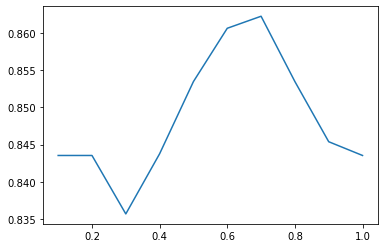

In [108]:
plt.plot( max_features, accuracy_scores )

- Al variar el parámetro max_features entre cero y el 100% de los features se observa que el accuracy se maximiza con el 70% de features

# Exercise 8.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [116]:
bagged_trees_log_features = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_features='log2'), 
                                     n_estimators = 10, 
                                     random_state = 42 )
bagged_trees_log_features.fit(X_train, y_train)
y_pred = bagged_trees_log_features.predict(X_test)
accuracy_score(y_test, y_pred)

0.8400921658986175

# Exercise 8.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score


rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred=rf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8382488479262673


# Exercise 8.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

Text(0, 0.5, 'Accuracy')

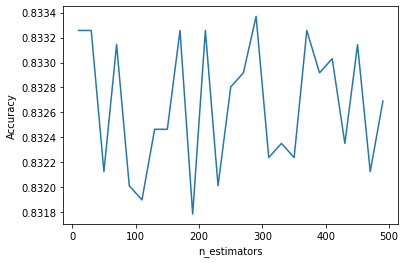

In [16]:
# list of values to try for n_estimators
estimator_range = range(10, 500, 20)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(rf, X_train, y_train, cv=2, scoring='accuracy').mean())

plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [17]:
# define features: exclude career statistics (which start with "C") and the response (Salary)
feature_cols = data.columns.drop('HighPrice')
feature_cols

Index(['Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL',
       'M_CamryLE', 'M_CamrySE', 'M_CamryXLE'],
      dtype='object')

Text(0, 0.5, 'Accuracy')

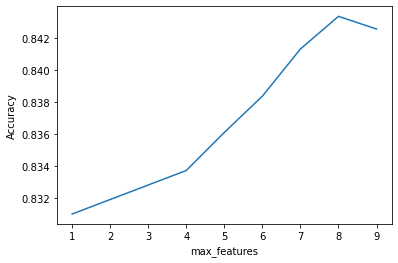

In [18]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=300, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=2, scoring='accuracy').mean())
    

plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

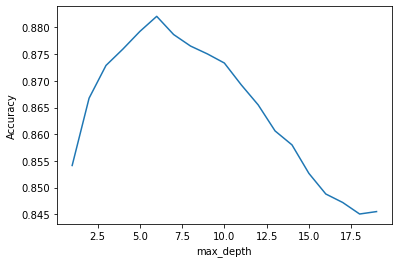

In [19]:
# list of values to try for max_depth
depth_range = range(1,20,1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for depth in depth_range:
    clf = RandomForestClassifier(n_estimators=300, max_features= 8, max_depth= depth, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=2, scoring='accuracy').mean())
    

plt.plot(depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [20]:
rf = RandomForestClassifier(max_depth = 6, n_estimators = 300, max_features = 8)
rf.fit(X_train, y_train)

y_pred=rf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8811059907834101


# Exercise 8.7 

Using xgboost train a XGBClassifier 

Evaluate the accuracy on the testing set

In [24]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred=xgb.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:42:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.8790322580645161


# Exercise 8.8

Using xgboost train a XGBClassifier 

Modify the parameters learning rate, gamma, colsample_bytree. Explain what each parameter means.

Evaluate the accuracy on the testing set

## Tasa de aprendizaje

En el machine learning, la tasa de aprendizaje es un parámetro de ajuste óptimo de varios tipos de modelos que determina el tamaño del paso en cada iteración mientras se mueve hacía un mínimo de una función de pérdida; en la literatura este se conoce también como la ganancia.

In [25]:
# Change learning rate
xgb = XGBClassifier(learning_rate = 0.1)
xgb.fit(X_train, y_train)
y_pred=xgb.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

[23:43:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.8794930875576037


## Colsample by tree

Este parámetro denota la fracción de columnas que serán seleccionadas al azar para cada árbol, los valores que puede tomar se encuentra entre 0.5 y 1, el default se encuentra en 1.

In [26]:
# Change colsample by tree
xgb = XGBClassifier(colsample_by_tree = 0.8)
xgb.fit(X_train, y_train)
y_pred=xgb.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

[23:44:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { colsample_by_tree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:44:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.8790322580645161


## Gamma

El algoritmo busca una reducción mínima de pérdidas para realizar partición en un nodo hoja del árbol. Cuanto mayor sea la gamma, más conservador será el algoritmo.

El algoritmo busca una reducción mínima de pérdidas para realizar partición en un nodo hoja del árbol. Cuanto mayor sea la gamma, más conservador será el algoritmo.

In [27]:
# Change colsample by tree
xgb = XGBClassifier(gamma = 2)
xgb.fit(X_train, y_train)
y_pred=xgb.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

[23:45:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.880184331797235
